# In-Situ Validation Analysis

Aggregate and visualize in-situ validation results from the Lake CCI gap-filling pipeline.

**Author:** Shaerdan / NCEO / University of Reading  
**Date:** December 2024

## 1. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from pathlib import Path

# Plot settings
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Tolerance for considering RMSE values as equal (smaller differences = tie)
RMSE_TOLERANCE = 1e-6

%matplotlib inline

## 2. Configuration

**Edit these paths for your experiment:**

In [2]:
# ============== EDIT THIS ==============
RUN_ROOT = "/gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3"
OUTPUT_DIR = None  # Set to a path, or None to use {RUN_ROOT}/insitu_analysis
# =======================================

# Resolve output directory
if OUTPUT_DIR is None:
    OUTPUT_DIR = os.path.join(RUN_ROOT, "insitu_analysis")

os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Run root:   {RUN_ROOT}")
print(f"Output dir: {OUTPUT_DIR}")

Run root:   /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3
Output dir: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis


## 3. Find and Load In-Situ CSV Files

In [3]:
def find_insitu_csvs(run_root: str):
    """
    Find all in-situ validation CSV files.
    Pattern: {run_root}/post/{lake_id}/a1000/insitu_cv_validation/LAKE*_insitu_stats_*.csv
    """
    post_dir = Path(run_root) / "post"
    if not post_dir.exists():
        print(f"Post directory not found: {post_dir}")
        return []
    
    csvs = []
    for lake_dir in post_dir.iterdir():
        if not lake_dir.is_dir():
            continue
        
        for alpha_dir in lake_dir.iterdir():
            if not alpha_dir.is_dir() or not alpha_dir.name.startswith("a"):
                continue
            
            insitu_dir = alpha_dir / "insitu_cv_validation"
            if insitu_dir.exists():
                csvs.extend(insitu_dir.glob("LAKE*_insitu_stats_*.csv"))
    
    return sorted(csvs)

# Find files
csv_files = find_insitu_csvs(RUN_ROOT)
print(f"Found {len(csv_files)} in-situ CSV files total")

# Separate main stats from yearly stats
main_csv_files = [f for f in csv_files if '_yearly_' not in f.name]
yearly_csv_files = [f for f in csv_files if '_yearly_' in f.name]
print(f"  - Main stats files: {len(main_csv_files)}")
print(f"  - Yearly stats files: {len(yearly_csv_files)}")

if main_csv_files:
    print("\nFirst 5 main stats files:")
    for f in main_csv_files[:5]:
        print(f"  {f.name}")

Found 86 in-situ CSV files total
  - Main stats files: 43
  - Yearly stats files: 43

First 5 main stats files:
  LAKE000000020_insitu_stats_site1.0.csv
  LAKE000000044_insitu_stats_site1.0.csv
  LAKE000000052_insitu_stats_site1.0.csv
  LAKE000000146_insitu_stats_site1.0.csv
  LAKE000000165_insitu_stats_site1.0.csv


In [4]:
def load_all_insitu_results(csv_files):
    """Load all in-situ CSV files into one DataFrame."""
    all_dfs = []
    
    for csv_file in csv_files:
        try:
            df = pd.read_csv(csv_file)
            df['source_file'] = csv_file.name
            df['is_yearly'] = '_yearly_' in csv_file.name
            all_dfs.append(df)
        except Exception as e:
            print(f"Warning: Could not read {csv_file}: {e}")
    
    if not all_dfs:
        return pd.DataFrame()
    
    return pd.concat(all_dfs, ignore_index=True)

# Load ALL data (main + yearly)
df_all = load_all_insitu_results(csv_files)
print(f"Loaded {len(df_all)} rows total from {len(csv_files)} files")

# Create separate dataframes
df_main = df_all[~df_all['is_yearly']].copy()
df_yearly = df_all[df_all['is_yearly']].copy()

print(f"\nMain stats: {len(df_main)} rows")
print(f"Yearly stats: {len(df_yearly)} rows")
print(f"\nUnique lakes: {df_main['lake_id'].nunique()}")
print(f"Methods: {df_main['method'].unique().tolist()}")
print(f"Data types: {df_main['data_type'].unique().tolist()}")

# Use main stats for summary comparisons
df = df_main

Loaded 4790 rows total from 86 files

Main stats: 308 rows
Yearly stats: 4482 rows

Unique lakes: 24
Methods: ['dineof', 'dincae', 'eof_filtered', 'interp_full', 'eof_filtered_interp_full']
Data types: ['observation', 'reconstruction']


In [5]:
# Preview the main data
df.head(10)

,lake_id,lake_id_cci,site_id,method,data_type,n_matches,rmse,mae,bias,median,std,rstd,correlation,source_file,is_yearly,year
0,20.0,20,1.0,dineof,observation,299,1.264219,0.912911,-0.818664,-0.689987,0.964962,0.700511,0.851885,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
1,20.0,20,1.0,dineof,reconstruction,409,0.908695,0.759400,-0.622124,-0.655553,0.663147,0.662175,0.918630,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
2,20.0,20,1.0,dincae,observation,299,1.264219,0.912911,-0.818664,-0.689987,0.964962,0.700511,0.851885,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
3,20.0,20,1.0,dincae,reconstruction,409,0.931527,0.764378,-0.638993,-0.649252,0.678643,0.671629,0.919676,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
4,20.0,20,1.0,eof_filtered,observation,299,1.264219,0.912911,-0.818664,-0.689987,0.964962,0.700511,0.851885,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
5,20.0,20,1.0,eof_filtered,reconstruction,409,0.908697,0.759402,-0.622126,-0.655553,0.663147,0.662152,0.918630,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
6,20.0,20,1.0,interp_full,reconstruction,561,0.927332,0.761268,-0.637014,-0.631934,0.674513,0.677662,0.911359,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
7,20.0,20,1.0,eof_filtered_interp_full,reconstruction,561,0.927332,0.761268,-0.637014,-0.631934,0.674513,0.677662,0.911359,LAKE000000020_insitu_stats_site1.0.csv,False,NaN
40,44.0,44,1.0,dineof,observation,590,0.813830,0.553373,-0.084391,-0.069995,0.810129,0.548563,0.975936,LAKE000000044_insitu_stats_site1.0.csv,False,NaN
41,44.0,44,1.0,dineof,reconstruction,1199,0.795108,0.581044,-0.025232,-0.079565,0.795039,0.624063,0.975572,LAKE000000044_insitu_stats_site1.0.csv,False,NaN


## 4. Create Summary DataFrame

One row per lake with all methods as columns for easy comparison.

**Note:** Uses only main stats files (not yearly) to ensure consistent comparisons.

**FIX:** Ties (identical RMSE values) are now counted separately, not as wins for either method.

In [6]:
def determine_winner(rmse_a, rmse_b, name_a, name_b, tol=RMSE_TOLERANCE):
    """
    Determine winner based on RMSE comparison with tolerance for ties.
    
    Returns:
        name_a (lowercase): if method A has lower RMSE (better)
        name_b (lowercase): if method B has lower RMSE (better)
        'tie': if RMSE values are equal within tolerance
    """
    diff = rmse_a - rmse_b
    if abs(diff) < tol:
        return 'tie'
    elif diff > 0:  # A has higher RMSE, so B is better
        return name_b.lower()
    else:  # A has lower RMSE, so A is better
        return name_a.lower()

def create_summary_df(df):
    """
    Create summary DataFrame: one row per lake comparing methods.
    Focus on reconstruction data_type for fair comparison.
    
    IMPORTANT: Input df should be filtered to main stats only (not yearly)
    to ensure consistent comparisons across methods.
    """
    # Filter to reconstruction only (gap-filled outputs)
    recon = df[df['data_type'] == 'reconstruction'].copy()
    
    summary_rows = []
    
    for lake_id in recon['lake_id'].unique():
        lake_data = recon[recon['lake_id'] == lake_id]
        
        row = {'lake_id': int(lake_id)}
        
        for method in ['dineof', 'dincae', 'eof_filtered', 'interp_full', 'eof_filtered_interp_full']:
            method_data = lake_data[lake_data['method'] == method]
            
            if not method_data.empty:
                m = method_data.iloc[0]  # Take first site
                row[f'rmse_{method}'] = m['rmse']
                row[f'mae_{method}'] = m['mae']
                row[f'bias_{method}'] = m['bias']
                row[f'corr_{method}'] = m['correlation']
                row[f'n_{method}'] = m['n_matches']
        
        summary_rows.append(row)
    
    summary = pd.DataFrame(summary_rows)
    
    # DINEOF vs DINCAE
    if 'rmse_dineof' in summary.columns and 'rmse_dincae' in summary.columns:
        summary['rmse_diff_dineof_dincae'] = summary['rmse_dineof'] - summary['rmse_dincae']
        summary['winner_dineof_dincae'] = summary.apply(
            lambda r: determine_winner(r['rmse_dineof'], r['rmse_dincae'], 'dineof', 'dincae'),
            axis=1
        )
    
    # DINEOF vs EOF_FILTERED
    if 'rmse_dineof' in summary.columns and 'rmse_eof_filtered' in summary.columns:
        summary['rmse_diff_dineof_eof'] = summary['rmse_dineof'] - summary['rmse_eof_filtered']
        summary['winner_dineof_eof'] = summary.apply(
            lambda r: determine_winner(r['rmse_dineof'], r['rmse_eof_filtered'], 'dineof', 'eof_filtered'),
            axis=1
        )
    
    # INTERP_FULL vs EOF_FILTERED_INTERP_FULL
    if 'rmse_interp_full' in summary.columns and 'rmse_eof_filtered_interp_full' in summary.columns:
        summary['rmse_diff_interp_eof_interp'] = summary['rmse_interp_full'] - summary['rmse_eof_filtered_interp_full']
        summary['winner_interp_eof_interp'] = summary.apply(
            lambda r: determine_winner(r['rmse_interp_full'], r['rmse_eof_filtered_interp_full'], 
                                       'interp_full', 'eof_filtered_interp_full'),
            axis=1
        )
    
    return summary.sort_values('lake_id')

# Create summary using MAIN STATS ONLY
summary = create_summary_df(df)
print(f"Summary: {len(summary)} lakes")

# Show winner columns to verify tie detection
winner_cols = [c for c in summary.columns if c.startswith('winner_')]
print(f"\nWinner columns: {winner_cols}")
for col in winner_cols:
    print(f"  {col}: {summary[col].value_counts().to_dict()}")

summary.head(10)

Summary: 24 lakes

Winner columns: ['winner_dineof_dincae', 'winner_dineof_eof', 'winner_interp_eof_interp']
  winner_dineof_dincae: {'dineof': 12, 'dincae': 12}
  winner_dineof_eof: {'eof_filtered': 10, 'dineof': 7, 'tie': 7}
  winner_interp_eof_interp: {'tie': 13, 'eof_filtered_interp_full': 9, 'interp_full': 2}


,lake_id,rmse_dineof,mae_dineof,bias_dineof,corr_dineof,n_dineof,rmse_dincae,mae_dincae,bias_dincae,corr_dincae,...,mae_eof_filtered_interp_full,bias_eof_filtered_interp_full,corr_eof_filtered_interp_full,n_eof_filtered_interp_full,rmse_diff_dineof_dincae,winner_dineof_dincae,rmse_diff_dineof_eof,winner_dineof_eof,rmse_diff_interp_eof_interp,winner_interp_eof_interp
0,20,0.908695,0.759400,-0.622124,0.918630,409.0,0.931527,0.764378,-0.638993,0.919676,...,0.761268,-0.637014,0.911359,561.0,-0.022832,dineof,-1.601649e-06,dineof,0.000000,tie
1,44,0.795108,0.581044,-0.025232,0.975572,1199.0,1.327579,0.963468,0.047523,0.930047,...,0.675655,0.074510,0.969729,1982.0,-0.532471,dineof,-2.343610e-04,dineof,0.003129,eof_filtered_interp_full
2,52,0.430088,0.336934,0.158679,0.625120,52.0,0.550595,0.442570,0.323453,0.383643,...,0.359748,0.178709,0.359035,641.0,-0.120507,dineof,2.035488e-07,tie,0.000000,tie
3,146,1.165066,0.823542,-0.667560,0.984839,1430.0,1.202627,0.846783,-0.599749,0.981367,...,0.887291,-0.532980,0.981173,2645.0,-0.037560,dineof,7.221173e-03,eof_filtered,0.004551,eof_filtered_interp_full
4,165,1.381678,1.018608,-0.556790,0.945058,343.0,1.344925,1.035376,-0.426889,0.945085,...,1.006934,-0.468079,0.944892,560.0,0.036753,dincae,-1.851611e-03,dineof,-0.002358,interp_full
5,198,1.068897,0.796613,-0.699808,0.980670,1102.0,0.971569,0.729742,-0.528789,0.980263,...,0.800845,-0.495664,0.976003,2293.0,0.097327,dincae,1.489773e-02,eof_filtered,0.008943,eof_filtered_interp_full
6,236,1.251355,0.733557,-0.521597,0.966694,1296.0,1.233111,0.734913,-0.348449,0.961820,...,0.842153,-0.521118,0.960754,2536.0,0.018244,dincae,5.604504e-03,eof_filtered,0.002617,eof_filtered_interp_full
7,295,1.099486,0.797542,-0.689912,0.967613,167.0,0.820239,0.603294,-0.430205,0.977207,...,0.742883,-0.564384,0.972445,348.0,0.279248,dincae,2.458183e-02,eof_filtered,0.035806,eof_filtered_interp_full
8,310,NaN,NaN,NaN,NaN,NaN,1.231535,0.993411,0.338847,0.981086,...,NaN,NaN,NaN,NaN,NaN,dineof,NaN,dineof,NaN,interp_full
9,327,1.521887,1.206696,-0.638255,0.976191,208.0,1.470736,1.165369,-0.383987,0.973933,...,1.160046,-0.559973,0.974730,335.0,0.051150,dincae,5.076125e-02,eof_filtered,0.045782,eof_filtered_interp_full


## 5. Save CSV Files

In [7]:
# Save master CSV (all data including yearly)
master_csv = os.path.join(OUTPUT_DIR, "insitu_all_results.csv")
df_all.to_csv(master_csv, index=False)
print(f"Saved: {master_csv}")

# Save main stats only CSV
main_csv = os.path.join(OUTPUT_DIR, "insitu_main_results.csv")
df_main.to_csv(main_csv, index=False)
print(f"Saved: {main_csv}")

# Save summary CSV
summary_csv = os.path.join(OUTPUT_DIR, "insitu_summary.csv")
summary.to_csv(summary_csv, index=False)
print(f"Saved: {summary_csv}")

Saved: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis/insitu_all_results.csv
Saved: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis/insitu_main_results.csv
Saved: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis/insitu_summary.csv


## 6. Summary Statistics

In [8]:
def print_comparison_stats(summary, diff_col, winner_col, name_a, name_b):
    """Print comparison statistics with proper handling of ties."""
    if winner_col not in summary.columns:
        return
    
    valid = summary.dropna(subset=[diff_col])
    if len(valid) == 0:
        return
    
    # Count wins - winner column contains lowercase method names or 'tie'
    n_a_wins = (valid[winner_col] == name_a.lower()).sum()
    n_b_wins = (valid[winner_col] == name_b.lower()).sum()
    n_ties = (valid[winner_col] == 'tie').sum()
    
    print(f"\n{name_a} vs {name_b}:")
    print(f"  {name_a} better: {n_a_wins} lakes ({100*n_a_wins/len(valid):.1f}%)")
    print(f"  {name_b} better: {n_b_wins} lakes ({100*n_b_wins/len(valid):.1f}%)")
    print(f"  Tie (identical): {n_ties} lakes ({100*n_ties/len(valid):.1f}%)")
    print(f"  Mean RMSE diff: {valid[diff_col].mean():.4f}")

print("=" * 70)
print("IN-SITU VALIDATION SUMMARY")
print("=" * 70)
print(f"\nTotal lakes with in-situ data: {len(summary)}")
print(f"Tie tolerance: {RMSE_TOLERANCE}")

for method in ['dineof', 'dincae', 'eof_filtered', 'interp_full', 'eof_filtered_interp_full']:
    col = f'rmse_{method}'
    if col in summary.columns:
        valid = summary[col].dropna()
        if len(valid) > 0:
            print(f"\n{method.upper()}:")
            print(f"  Lakes: {len(valid)}")
            print(f"  RMSE:  mean={valid.mean():.3f}, median={valid.median():.3f}, std={valid.std():.3f}")
            print(f"         min={valid.min():.3f}, max={valid.max():.3f}")

# Comparisons with tie handling
print_comparison_stats(summary, 'rmse_diff_dineof_dincae', 'winner_dineof_dincae', 'DINEOF', 'DINCAE')
print_comparison_stats(summary, 'rmse_diff_dineof_eof', 'winner_dineof_eof', 'DINEOF', 'EOF_FILTERED')
print_comparison_stats(summary, 'rmse_diff_interp_eof_interp', 'winner_interp_eof_interp', 'INTERP_FULL', 'EOF_FILTERED_INTERP_FULL')

print("=" * 70)

IN-SITU VALIDATION SUMMARY

Total lakes with in-situ data: 24
Tie tolerance: 1e-06

DINEOF:
  Lakes: 23
  RMSE:  mean=1.134, median=1.099, std=0.305
         min=0.430, max=1.972

DINCAE:
  Lakes: 24
  RMSE:  mean=1.139, median=1.121, std=0.309
         min=0.551, max=2.061

EOF_FILTERED:
  Lakes: 23
  RMSE:  mean=1.123, median=1.076, std=0.300
         min=0.430, max=1.972

INTERP_FULL:
  Lakes: 23
  RMSE:  mean=1.212, median=1.220, std=0.361
         min=0.528, max=2.349

EOF_FILTERED_INTERP_FULL:
  Lakes: 23
  RMSE:  mean=1.205, median=1.213, std=0.360
         min=0.528, max=2.349

DINEOF vs DINCAE:
  DINEOF better: 11 lakes (47.8%)
  DINCAE better: 12 lakes (52.2%)
  Tie (identical): 0 lakes (0.0%)
  Mean RMSE diff: -0.0014

DINEOF vs EOF_FILTERED:
  DINEOF better: 6 lakes (26.1%)
  EOF_FILTERED better: 10 lakes (43.5%)
  Tie (identical): 7 lakes (30.4%)
  Mean RMSE diff: 0.0111

INTERP_FULL vs EOF_FILTERED_INTERP_FULL:
  INTERP_FULL better: 1 lakes (4.3%)
  EOF_FILTERED_INTERP_FU

## 7. Visualizations

### 7.1 RMSE Comparison by Lake (DINEOF vs DINCAE)

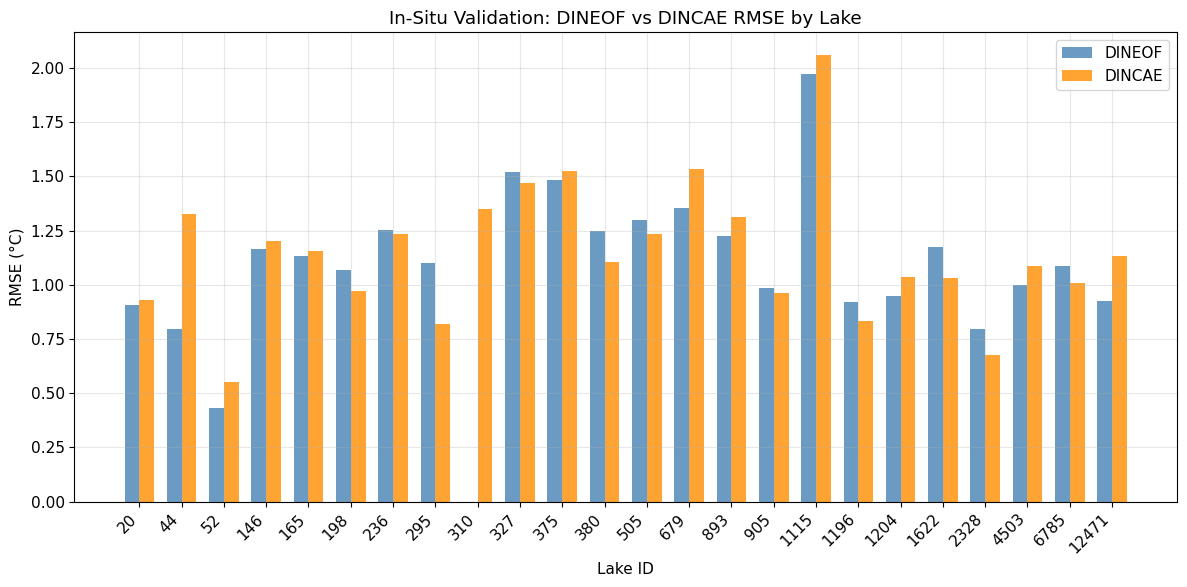

In [9]:
# Filter to reconstruction and main methods (using main stats df)
recon = df[(df['data_type'] == 'reconstruction') & 
           (df['method'].isin(['dineof', 'dincae']))].copy()

if not recon.empty:
    # Pivot for plotting
    pivot = recon.pivot_table(
        index='lake_id', 
        columns='method', 
        values='rmse',
        aggfunc='mean'
    ).reset_index().sort_values('lake_id')
    
    n_lakes = len(pivot)
    fig_width = max(12, n_lakes * 0.4)
    
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    x = np.arange(n_lakes)
    width = 0.35
    
    if 'dineof' in pivot.columns:
        ax.bar(x - width/2, pivot['dineof'], width, label='DINEOF', color='steelblue', alpha=0.8)
    if 'dincae' in pivot.columns:
        ax.bar(x + width/2, pivot['dincae'], width, label='DINCAE', color='darkorange', alpha=0.8)
    
    ax.set_xlabel('Lake ID')
    ax.set_ylabel('RMSE (°C)')
    ax.set_title('In-Situ Validation: DINEOF vs DINCAE RMSE by Lake')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(lid)}" for lid in pivot['lake_id']], rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_comparison_dineof_vs_dincae.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for DINEOF vs DINCAE comparison plot")

### 7.2 DINEOF vs DINCAE Summary (Pie + Histogram)

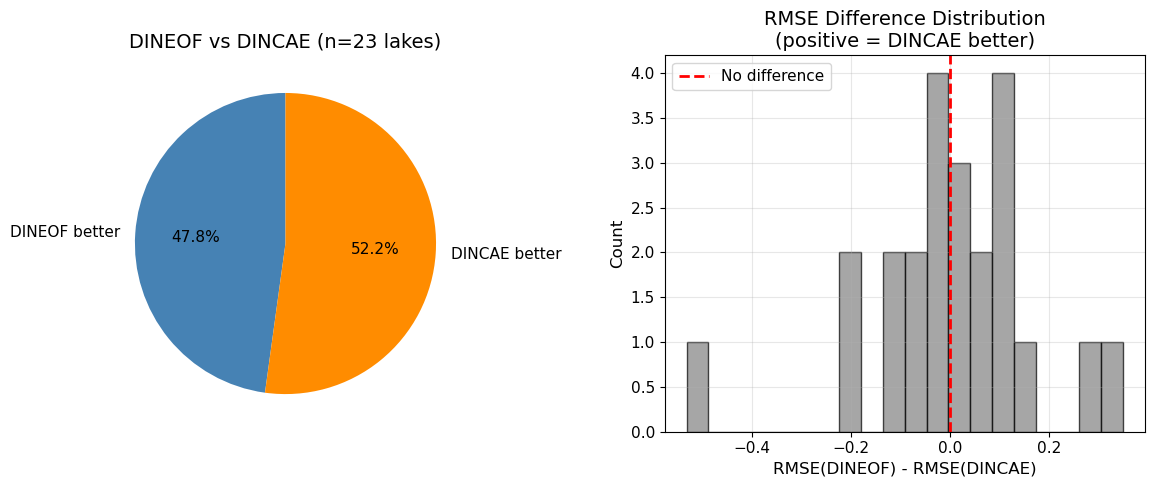

  DINEOF better: 11, DINCAE better: 12, Tie: 0


In [10]:
def plot_comparison_summary(summary, diff_col, winner_col, name_a, name_b, color_a, color_b, output_dir, filename):
    """
    Plot pie chart (with 3 categories: A better, B better, Tie) and histogram.
    """
    if winner_col not in summary.columns:
        print(f"No comparison data for {name_a} vs {name_b}")
        return
    
    valid = summary.dropna(subset=[diff_col])
    if len(valid) == 0:
        print(f"No data for {name_a} vs {name_b}")
        return
    
    # Count outcomes
    n_a_wins = (valid[winner_col] == name_a.lower()).sum()
    n_b_wins = (valid[winner_col] == name_b.lower()).sum()
    n_ties = (valid[winner_col] == 'tie').sum()
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Pie chart - always show 3 categories
    sizes = [n_a_wins, n_b_wins, n_ties]
    labels = [f'{name_a} better', f'{name_b} better', 'Tie']
    colors = [color_a, color_b, 'lightgray']
    
    # Filter out zeros for cleaner pie chart
    non_zero = [(s, l, c) for s, l, c in zip(sizes, labels, colors) if s > 0]
    if non_zero:
        sizes_nz, labels_nz, colors_nz = zip(*non_zero)
        wedges, texts, autotexts = axes[0].pie(
            sizes_nz, labels=labels_nz, colors=colors_nz, 
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11}
        )
    axes[0].set_title(f'{name_a} vs {name_b} (n={len(valid)} lakes)', fontsize=14)
    
    # Histogram
    rmse_diff = valid[diff_col]
    axes[1].hist(rmse_diff, bins=20, color='gray', edgecolor='black', alpha=0.7)
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='No difference')
    axes[1].set_xlabel(f'RMSE({name_a}) - RMSE({name_b})', fontsize=12)
    axes[1].set_ylabel('Count', fontsize=12)
    axes[1].set_title(f'RMSE Difference Distribution\n(positive = {name_b} better)', fontsize=14)
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, filename), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print(f"  {name_a} better: {n_a_wins}, {name_b} better: {n_b_wins}, Tie: {n_ties}")

# DINEOF vs DINCAE
plot_comparison_summary(summary, 'rmse_diff_dineof_dincae', 'winner_dineof_dincae',
                        'DINEOF', 'DINCAE', 'steelblue', 'darkorange',
                        OUTPUT_DIR, 'comparison_dineof_vs_dincae.png')

### 7.3 RMSE Comparison by Lake (DINEOF vs EOF_FILTERED)

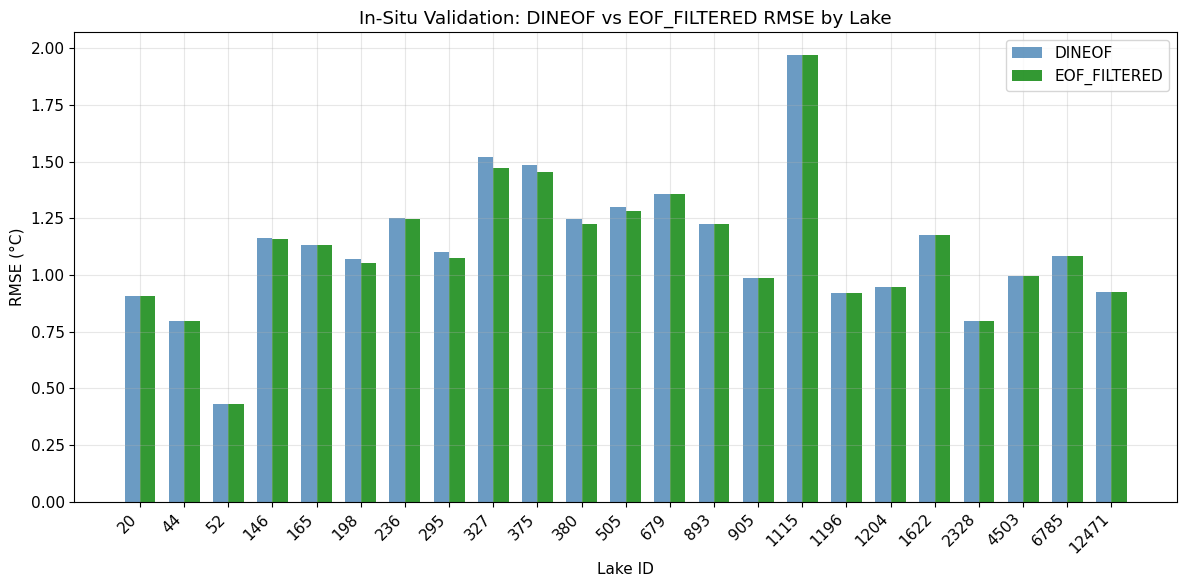

In [11]:
# Filter to reconstruction and EOF methods
recon = df[(df['data_type'] == 'reconstruction') & 
           (df['method'].isin(['dineof', 'eof_filtered']))].copy()

if not recon.empty:
    # Pivot for plotting
    pivot = recon.pivot_table(
        index='lake_id', 
        columns='method', 
        values='rmse',
        aggfunc='mean'
    ).reset_index().sort_values('lake_id')
    
    n_lakes = len(pivot)
    fig_width = max(12, n_lakes * 0.4)
    
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    x = np.arange(n_lakes)
    width = 0.35
    
    if 'dineof' in pivot.columns:
        ax.bar(x - width/2, pivot['dineof'], width, label='DINEOF', color='steelblue', alpha=0.8)
    if 'eof_filtered' in pivot.columns:
        ax.bar(x + width/2, pivot['eof_filtered'], width, label='EOF_FILTERED', color='green', alpha=0.8)
    
    ax.set_xlabel('Lake ID')
    ax.set_ylabel('RMSE (°C)')
    ax.set_title('In-Situ Validation: DINEOF vs EOF_FILTERED RMSE by Lake')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(lid)}" for lid in pivot['lake_id']], rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_comparison_dineof_vs_eof_filtered.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for DINEOF vs EOF_FILTERED comparison plot")

### 7.4 DINEOF vs EOF_FILTERED Summary (Pie + Histogram)

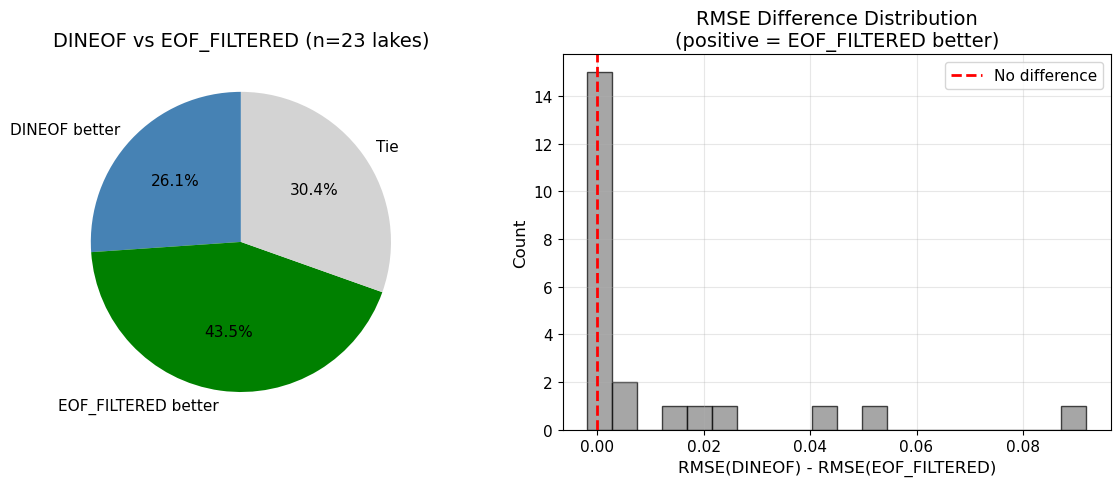

  DINEOF better: 6, EOF_FILTERED better: 10, Tie: 7


In [12]:
plot_comparison_summary(summary, 'rmse_diff_dineof_eof', 'winner_dineof_eof',
                        'DINEOF', 'EOF_FILTERED', 'steelblue', 'green',
                        OUTPUT_DIR, 'comparison_dineof_vs_eof_filtered.png')

### 7.5 RMSE Comparison by Lake (INTERP_FULL vs EOF_FILTERED_INTERP_FULL)

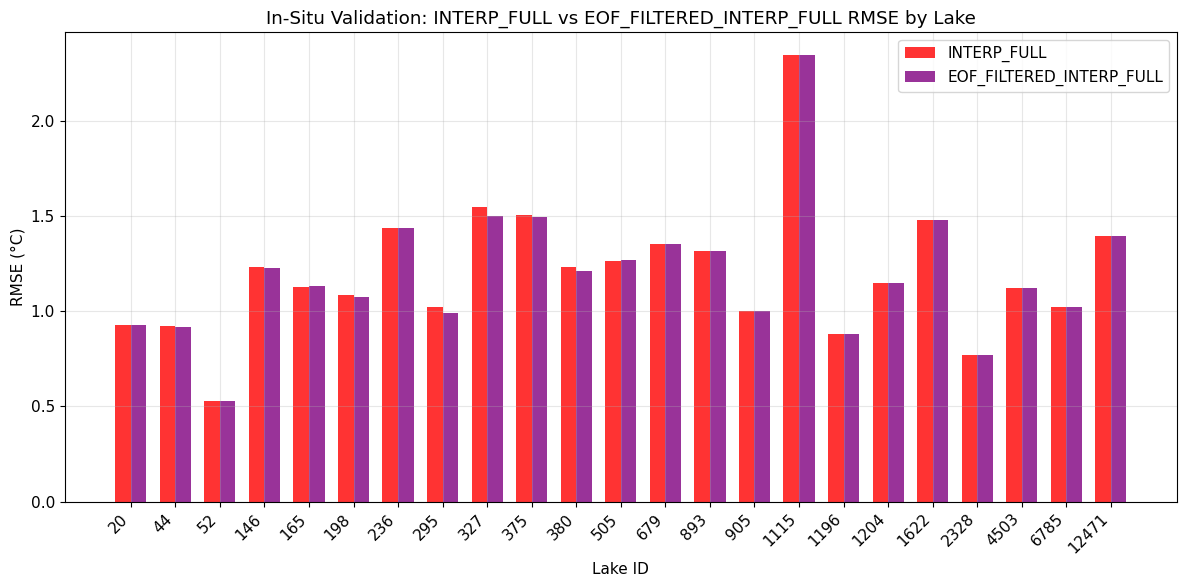

In [13]:
# Filter to reconstruction and interpolated methods
recon = df[(df['data_type'] == 'reconstruction') & 
           (df['method'].isin(['interp_full', 'eof_filtered_interp_full']))].copy()

if not recon.empty:
    # Pivot for plotting
    pivot = recon.pivot_table(
        index='lake_id', 
        columns='method', 
        values='rmse',
        aggfunc='mean'
    ).reset_index().sort_values('lake_id')
    
    n_lakes = len(pivot)
    fig_width = max(12, n_lakes * 0.4)
    
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    x = np.arange(n_lakes)
    width = 0.35
    
    if 'interp_full' in pivot.columns:
        ax.bar(x - width/2, pivot['interp_full'], width, label='INTERP_FULL', color='red', alpha=0.8)
    if 'eof_filtered_interp_full' in pivot.columns:
        ax.bar(x + width/2, pivot['eof_filtered_interp_full'], width, label='EOF_FILTERED_INTERP_FULL', color='purple', alpha=0.8)
    
    ax.set_xlabel('Lake ID')
    ax.set_ylabel('RMSE (°C)')
    ax.set_title('In-Situ Validation: INTERP_FULL vs EOF_FILTERED_INTERP_FULL RMSE by Lake')
    ax.set_xticks(x)
    ax.set_xticklabels([f"{int(lid)}" for lid in pivot['lake_id']], rotation=45, ha='right')
    ax.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_comparison_interp_vs_eof_interp.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for INTERP_FULL vs EOF_FILTERED_INTERP_FULL comparison plot")

### 7.6 INTERP_FULL vs EOF_FILTERED_INTERP_FULL Summary (Pie + Histogram)

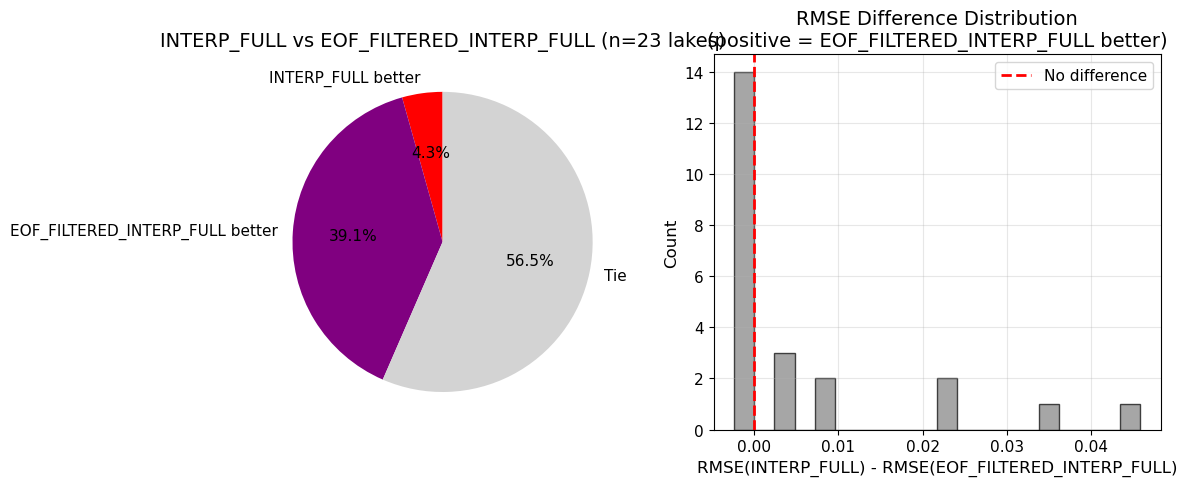

  INTERP_FULL better: 1, EOF_FILTERED_INTERP_FULL better: 9, Tie: 13


In [14]:
plot_comparison_summary(summary, 'rmse_diff_interp_eof_interp', 'winner_interp_eof_interp',
                        'INTERP_FULL', 'EOF_FILTERED_INTERP_FULL', 'red', 'purple',
                        OUTPUT_DIR, 'comparison_interp_vs_eof_interp.png')

### 7.7 RMSE vs Correlation Scatter Plot

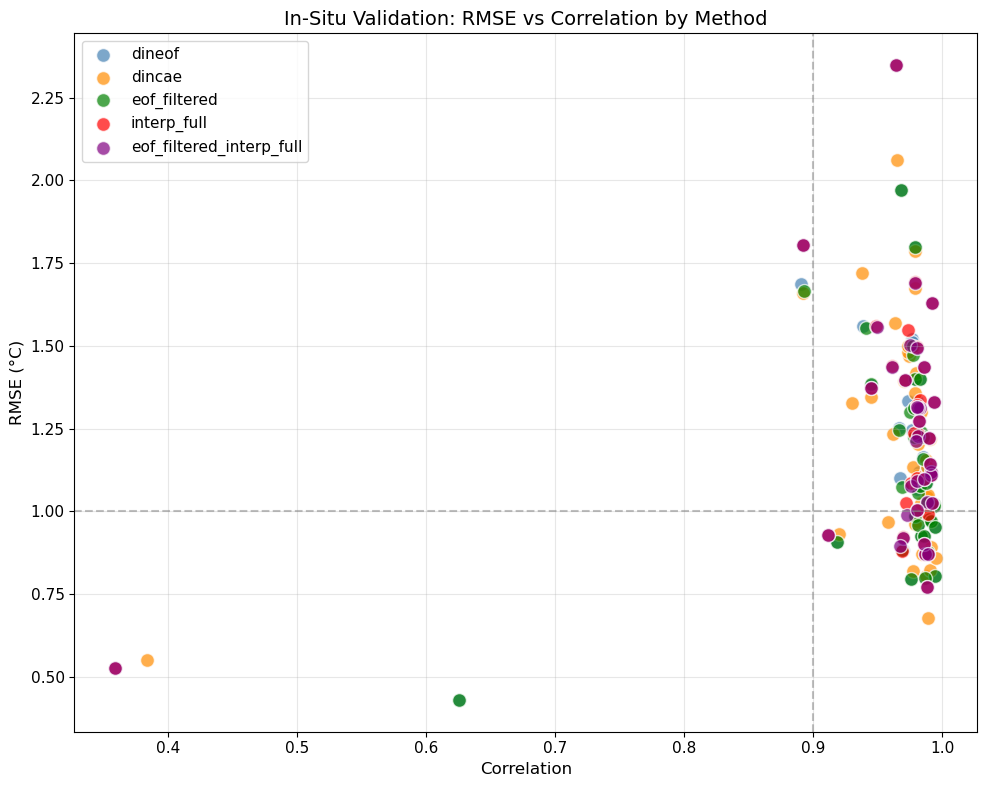

In [15]:
recon = df[df['data_type'] == 'reconstruction'].copy()

if not recon.empty:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = {
        'dineof': 'steelblue',
        'dincae': 'darkorange',
        'eof_filtered': 'green',
        'interp_full': 'red',
        'eof_filtered_interp_full': 'purple'
    }
    
    for method in recon['method'].unique():
        method_data = recon[recon['method'] == method]
        ax.scatter(
            method_data['correlation'], 
            method_data['rmse'],
            c=colors.get(method, 'gray'),
            label=method,
            alpha=0.7,
            s=100,
            edgecolors='white'
        )
    
    ax.set_xlabel('Correlation', fontsize=12)
    ax.set_ylabel('RMSE (°C)', fontsize=12)
    ax.set_title('In-Situ Validation: RMSE vs Correlation by Method', fontsize=14)
    ax.legend(loc='upper left')
    
    # Reference lines
    ax.axhline(y=1.0, color='gray', linestyle='--', alpha=0.5)
    ax.axvline(x=0.9, color='gray', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_vs_correlation.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for scatter plot")

### 7.8 Metrics Box Plots by Method

/tmp/ipykernel_6851/3145847226.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = axes[0].boxplot(data_rmse, labels=methods_present, patch_artist=True)
/tmp/ipykernel_6851/3145847226.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = axes[1].boxplot(data_mae, labels=methods_present, patch_artist=True)
/tmp/ipykernel_6851/3145847226.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = axes[2].boxplot(data_corr, labels=methods_present, patch_artist=True)


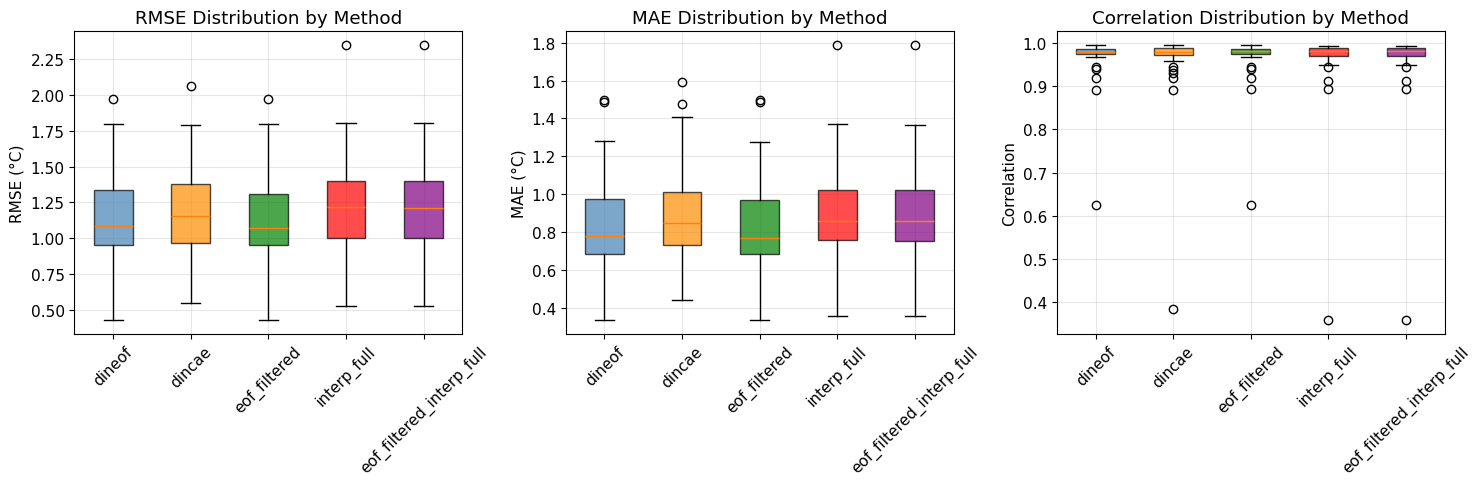

In [16]:
recon = df[df['data_type'] == 'reconstruction'].copy()

if not recon.empty:
    method_order = ['dineof', 'dincae', 'eof_filtered', 'interp_full', 'eof_filtered_interp_full']
    methods_present = [m for m in method_order if m in recon['method'].unique()]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = ['steelblue', 'darkorange', 'green', 'red', 'purple']
    
    # RMSE
    data_rmse = [recon[recon['method'] == m]['rmse'].dropna() for m in methods_present]
    bp1 = axes[0].boxplot(data_rmse, labels=methods_present, patch_artist=True)
    axes[0].set_ylabel('RMSE (°C)')
    axes[0].set_title('RMSE Distribution by Method')
    axes[0].tick_params(axis='x', rotation=45)
    
    # MAE
    data_mae = [recon[recon['method'] == m]['mae'].dropna() for m in methods_present]
    bp2 = axes[1].boxplot(data_mae, labels=methods_present, patch_artist=True)
    axes[1].set_ylabel('MAE (°C)')
    axes[1].set_title('MAE Distribution by Method')
    axes[1].tick_params(axis='x', rotation=45)
    
    # Correlation
    data_corr = [recon[recon['method'] == m]['correlation'].dropna() for m in methods_present]
    bp3 = axes[2].boxplot(data_corr, labels=methods_present, patch_artist=True)
    axes[2].set_ylabel('Correlation')
    axes[2].set_title('Correlation Distribution by Method')
    axes[2].tick_params(axis='x', rotation=45)
    
    # Color boxes
    for bp in [bp1, bp2, bp3]:
        for patch, color in zip(bp['boxes'], colors[:len(methods_present)]):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'metrics_boxplot.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for box plots")

### 7.9 RMSE Heatmap (Lakes × Methods)

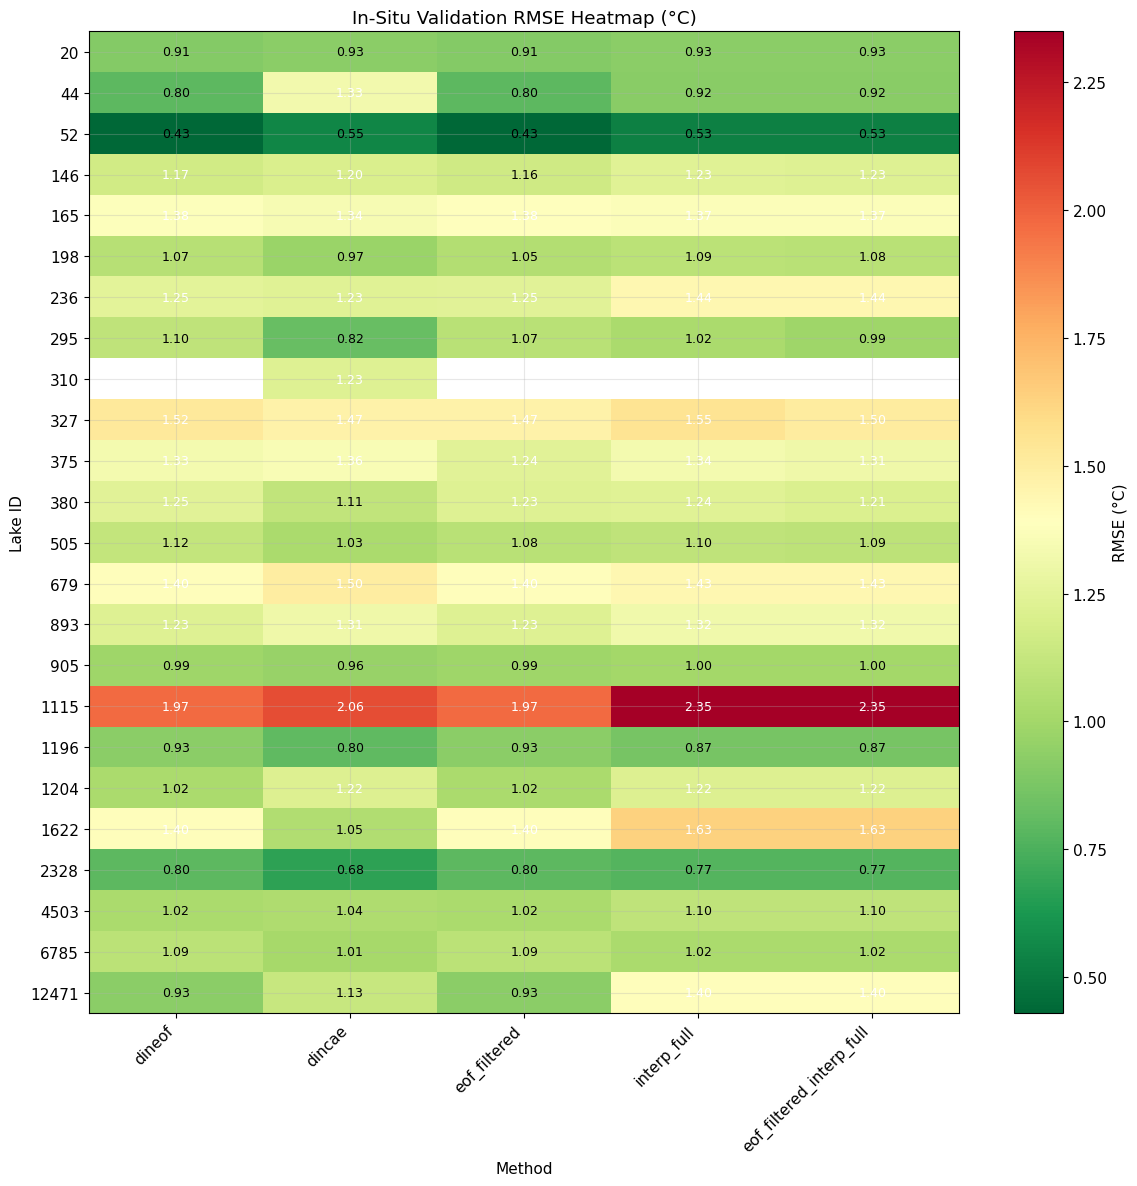

In [17]:
rmse_cols = [c for c in summary.columns if c.startswith('rmse_') and not c.startswith('rmse_diff')]

if rmse_cols and len(summary) > 0:
    matrix = summary[['lake_id'] + rmse_cols].set_index('lake_id')
    matrix.columns = [c.replace('rmse_', '') for c in matrix.columns]
    
    fig, ax = plt.subplots(figsize=(12, max(6, len(matrix) * 0.5)))
    
    im = ax.imshow(matrix.values, cmap='RdYlGn_r', aspect='auto')
    
    ax.set_xticks(np.arange(len(matrix.columns)))
    ax.set_yticks(np.arange(len(matrix)))
    ax.set_xticklabels(matrix.columns, rotation=45, ha='right')
    ax.set_yticklabels([f"{int(lid)}" for lid in matrix.index])
    
    ax.set_xlabel('Method')
    ax.set_ylabel('Lake ID')
    ax.set_title('In-Situ Validation RMSE Heatmap (°C)')
    
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('RMSE (°C)')
    
    # Add text annotations
    valid_vals = matrix.values[~np.isnan(matrix.values)]
    if len(valid_vals) > 0:
        mean_val = valid_vals.mean()
        for i in range(len(matrix)):
            for j in range(len(matrix.columns)):
                val = matrix.iloc[i, j]
                if not np.isnan(val):
                    text_color = 'white' if val > mean_val else 'black'
                    ax.text(j, i, f'{val:.2f}', ha='center', va='center', color=text_color, fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'rmse_heatmap.png'), dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("No data for heatmap")

## 8. Interactive Exploration

In [18]:
# Explore data for a specific lake (from main stats only)
def show_lake_details(lake_id):
    """Show all in-situ validation data for a specific lake."""
    lake_data = df[df['lake_id'] == lake_id]
    if lake_data.empty:
        print(f"No data for lake {lake_id}")
        return
    
    print(f"\n{'='*60}")
    print(f"Lake {lake_id} - In-Situ Validation Results (Main Stats)")
    print(f"{'='*60}")
    
    # Show reconstruction results
    recon = lake_data[lake_data['data_type'] == 'reconstruction']
    if not recon.empty:
        print("\nReconstruction:")
        print(recon[['method', 'n_matches', 'rmse', 'mae', 'bias', 'correlation']].to_string(index=False))
    
    # Show observation results
    obs = lake_data[lake_data['data_type'] == 'observation']
    if not obs.empty:
        print("\nObservation (original sparse data):")
        print(obs[['method', 'n_matches', 'rmse', 'mae', 'bias', 'correlation']].to_string(index=False))

# Example: Show details for first lake
if len(df) > 0:
    example_lake = int(df['lake_id'].iloc[0])
    show_lake_details(example_lake)


Lake 20 - In-Situ Validation Results (Main Stats)

Reconstruction:
                  method  n_matches     rmse      mae      bias  correlation
                  dineof        409 0.908695 0.759400 -0.622124     0.918630
                  dincae        409 0.931527 0.764378 -0.638993     0.919676
            eof_filtered        409 0.908697 0.759402 -0.622126     0.918630
             interp_full        561 0.927332 0.761268 -0.637014     0.911359
eof_filtered_interp_full        561 0.927332 0.761268 -0.637014     0.911359

Observation (original sparse data):
      method  n_matches     rmse      mae      bias  correlation
      dineof        299 1.264219 0.912911 -0.818664     0.851885
      dincae        299 1.264219 0.912911 -0.818664     0.851885
eof_filtered        299 1.264219 0.912911 -0.818664     0.851885


In [19]:
# Show yearly breakdown for a specific lake (if available)
def show_lake_yearly(lake_id):
    """Show yearly breakdown for a specific lake."""
    lake_data = df_yearly[df_yearly['lake_id'] == lake_id]
    if lake_data.empty:
        print(f"No yearly data for lake {lake_id}")
        return
    
    print(f"\n{'='*60}")
    print(f"Lake {lake_id} - Yearly Breakdown")
    print(f"{'='*60}")
    
    recon = lake_data[lake_data['data_type'] == 'reconstruction']
    if not recon.empty and 'year' in recon.columns:
        for method in recon['method'].unique():
            method_data = recon[recon['method'] == method].sort_values('year')
            print(f"\n{method.upper()}:")
            print(method_data[['year', 'n_matches', 'rmse', 'mae', 'bias', 'correlation']].to_string(index=False))

# Example: Show yearly details for first lake
if len(df_yearly) > 0:
    example_lake = int(df_yearly['lake_id'].iloc[0])
    show_lake_yearly(example_lake)


Lake 20 - Yearly Breakdown

DINEOF:
  year  n_matches     rmse      mae      bias  correlation
2019.0         57 0.622688 0.527598 -0.174302     0.943299
2020.0        173 0.885455 0.719503 -0.546697     0.873623
2021.0        168 0.975115 0.844520 -0.808136     0.949771
2022.0         11 1.356503 1.288013 -1.288013     0.873845

DINCAE:
  year  n_matches     rmse      mae      bias  correlation
2019.0         57 0.724476 0.588607 -0.348756     0.935442
2020.0        173 0.908226 0.742519 -0.603765     0.885808
2021.0        168 0.990577 0.824055 -0.743063     0.936056
2022.0         11 1.259045 1.107543 -1.107543     0.793567

EOF_FILTERED:
  year  n_matches     rmse      mae      bias  correlation
2019.0         57 0.622689 0.527598 -0.174303     0.943299
2020.0        173 0.885456 0.719505 -0.546699     0.873623
2021.0        168 0.975117 0.844522 -0.808139     0.949771
2022.0         11 1.356506 1.288016 -1.288016     0.873844

INTERP_FULL:
  year  n_matches     rmse      mae     

In [20]:
# List all lakes with in-situ data
print("Lakes with in-situ validation data:")
print(sorted(df['lake_id'].unique().astype(int).tolist()))

Lakes with in-situ validation data:
[20, 44, 52, 146, 165, 198, 236, 295, 310, 327, 375, 380, 505, 679, 893, 905, 1115, 1196, 1204, 1622, 2328, 4503, 6785, 12471]


## 9. Output Summary

In [21]:
print("\n" + "=" * 60)
print("OUTPUT FILES")
print("=" * 60)
print(f"\nDirectory: {OUTPUT_DIR}")
print("\nCSV files:")
print(f"  - insitu_all_results.csv     (all data incl. yearly, {len(df_all)} rows)")
print(f"  - insitu_main_results.csv    (main stats only, {len(df_main)} rows)")
print(f"  - insitu_summary.csv         (summary, {len(summary)} lakes)")
print("\nPlot files:")
print("  - rmse_comparison_dineof_vs_dincae.png")
print("  - comparison_dineof_vs_dincae.png")
print("  - rmse_comparison_dineof_vs_eof_filtered.png")
print("  - comparison_dineof_vs_eof_filtered.png")
print("  - rmse_comparison_interp_vs_eof_interp.png")
print("  - comparison_interp_vs_eof_interp.png")
print("  - rmse_vs_correlation.png")
print("  - metrics_boxplot.png")
print("  - rmse_heatmap.png")
print("=" * 60)


OUTPUT FILES

Directory: /gws/ssde/j25b/cds_c3s_lakes/users/SHAERDAN/anomaly-20251215-8ea02d-exp3/insitu_analysis

CSV files:
  - insitu_all_results.csv     (all data incl. yearly, 4790 rows)
  - insitu_main_results.csv    (main stats only, 308 rows)
  - insitu_summary.csv         (summary, 24 lakes)

Plot files:
  - rmse_comparison_dineof_vs_dincae.png
  - comparison_dineof_vs_dincae.png
  - rmse_comparison_dineof_vs_eof_filtered.png
  - comparison_dineof_vs_eof_filtered.png
  - rmse_comparison_interp_vs_eof_interp.png
  - comparison_interp_vs_eof_interp.png
  - rmse_vs_correlation.png
  - metrics_boxplot.png
  - rmse_heatmap.png
